In [1]:
import torch
import geomstats as gm
from models.train import train
from models.utils import load_model
from models.model import RiemannianAutoencoder
import numpy as np
!export GEOMSTATS_BACKEND=pytorch

INFO: Using numpy backend


### Generate Data from Trajectories of Gaussian Distributions

The parameter space ($\mu$ , $\sigma$ ) of univariate gaussians can be modeled by the Poincare half-plane. Thus, geodesics between two univariate gaussians should follow geodesics corresponding to the Hyperboloid space.

In [2]:
from geomstats.information_geometry.normal import NormalDistributions
dim = 2
space = NormalDistributions(sample_dim=dim-1)
N = 10
time_steps = 20
t = torch.linspace(0,1,time_steps)
input_points = space.random_point(n_samples = N)
input_tangent_vec = space.random_tangent_vec(input_points)
geodesic = space.metric.geodesic(initial_point=input_points, initial_tangent_vec = input_tangent_vec)
geodesic_trajectories =  geodesic(t)

#### Plotting Trajectories

Text(0.5, 1.0, 'Geodesics of Univariate Gaussians')

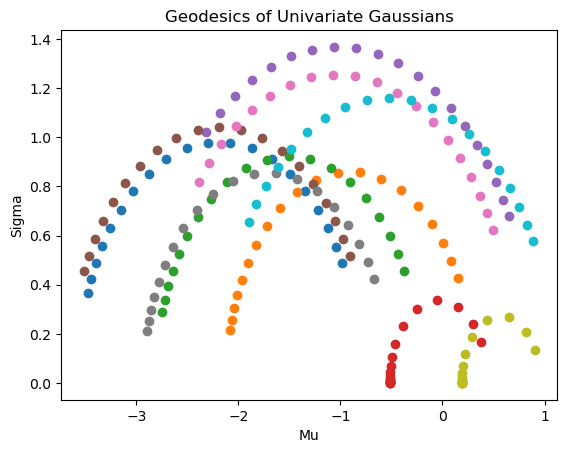

In [3]:
import matplotlib.pyplot as plt
for i in range(N):
    plt.scatter(geodesic_trajectories[i][:, 0], geodesic_trajectories[i][:, 1])
plt.xlabel("Mu")
plt.ylabel("Sigma")
plt.title("Geodesics of Univariate Gaussians")

### Train the Model

In [6]:
torch.set_default_dtype(torch.float32)
observed_trajectories = torch.from_numpy(geodesic_trajectories).to(torch.float32)
initial_conditions = torch.from_numpy(np.concatenate([input_points, input_tangent_vec], -1)).to(torch.float32)
model, preds = train(observed_trajectories, initial_conditions, val_initial_conditions=None, val_input_trajectories=None, epochs = 500, n = 2, t = time_steps, return_preds=True, val = False, model_type = "neural")

Epoch: 1, Loss: 0.7367276549339294, Val Loss: None
Epoch: 2, Loss: 0.5509227514266968, Val Loss: None
Epoch: 3, Loss: 0.3939095437526703, Val Loss: None
Epoch: 4, Loss: 0.25883549451828003, Val Loss: None
Epoch: 5, Loss: 0.1599959135055542, Val Loss: None
Epoch: 6, Loss: 0.11882781237363815, Val Loss: None
Epoch: 7, Loss: 0.14272341132164001, Val Loss: None
Epoch: 8, Loss: 0.17812742292881012, Val Loss: None
Epoch: 9, Loss: 0.17625102400779724, Val Loss: None
Epoch: 10, Loss: 0.1524200588464737, Val Loss: None
Epoch: 11, Loss: 0.12951986491680145, Val Loss: None
Epoch: 12, Loss: 0.11630582809448242, Val Loss: None
Epoch: 13, Loss: 0.11179698258638382, Val Loss: None
Epoch: 14, Loss: 0.11205607652664185, Val Loss: None
Epoch: 15, Loss: 0.11363185197114944, Val Loss: None
Epoch: 16, Loss: 0.11441001296043396, Val Loss: None
Epoch: 17, Loss: 0.11343301087617874, Val Loss: None
Epoch: 18, Loss: 0.11053545027971268, Val Loss: None
Epoch: 19, Loss: 0.10606022924184799, Val Loss: None
Epoch: 

In [7]:
model

RiemannianAutoencoder(
  (metric_space): NeuralRiemmanianMetric(
    (metric_function): PSD(
      (linear1): Linear(in_features=2, out_features=20, bias=True)
      (linear2): Linear(in_features=20, out_features=3, bias=True)
      (nonlinearity): Tanh()
    )
  )
  (ode_layer): NNODE(
    (odefunc): ODEFunc(
      (module): NeuralRiemmanianMetric(
        (metric_function): PSD(
          (linear1): Linear(in_features=2, out_features=20, bias=True)
          (linear2): Linear(in_features=20, out_features=3, bias=True)
          (nonlinearity): Tanh()
        )
      )
    )
    (neural_ode_layer): Neural ODE:
    	- order: 1        
    	- solver: DormandPrince45()
    	- adjoint solver: DormandPrince45()        
    	- tolerances: relative 0.001 absolute 0.001        
    	- adjoint tolerances: relative 0.0001 absolute 0.0001        
    	- num_parameters: 123        
    	- NFE: 200504.0
  )
)

#### Plotting the Training

Text(0.5, 1.0, 'Predicted Geodesics of Univariate Gaussians')

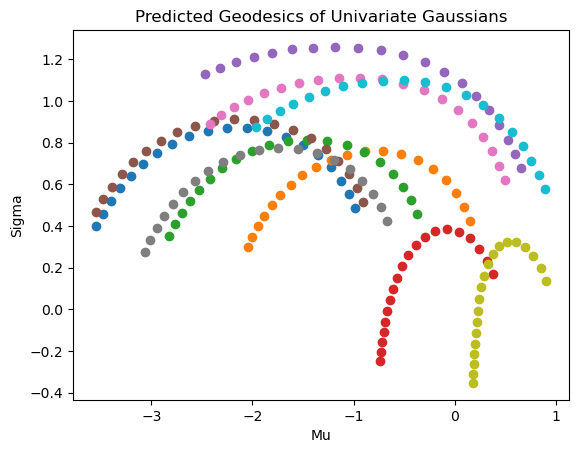

In [8]:
for i in range(N):
    plt.scatter(preds[-1][i][:, 0], preds[-1][i][:, 1])
plt.xlabel("Mu")
plt.ylabel("Sigma")
plt.title("Predicted Geodesics of Univariate Gaussians")

### Test Whales

In [2]:
model = load_model(RiemannianAutoencoder(3, 100, t =1), 1000, "whale")

In [79]:
import pandas as pd
from geomstats.geometry.hypersphere import Hypersphere
data = pd.read_csv("whale_data/clean_data.csv")
keep_whales = np.random.choice(pd.unique(data["individual-local-identifier"]), 30)
data = data[data["individual-local-identifier"].isin(keep_whales)]
feature_data = pd.read_csv("whale_data/feature_data.csv")
feature_data = feature_data[feature_data["individual-local-identifier"].isin(keep_whales)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trajectory_list =[ torch.from_numpy(item).to(device).float() for item in data.groupby("individual-local-identifier").apply(lambda x: x[["x","y","z"]].to_numpy()).to_list()]
timestep_list = [ torch.from_numpy(item).to(device).float() for item in data.groupby("individual-local-identifier").apply(lambda x: x["total_seconds_normalized"].to_numpy()).to_list()]

initial_velocity = np.concatenate(feature_data.groupby("individual-local-identifier").apply(lambda x: Hypersphere(2).to_tangent((x.head(1)[["x","y","z"]].to_numpy() - x.tail(1)[["x","y","z"]].to_numpy())/ x.tail(1)["total_seconds_normalized"].to_numpy(), x.head(1)[["x","y","z"]].to_numpy())).to_list())
initial_position = np.concatenate(feature_data.groupby("individual-local-identifier").apply(lambda x: x.head(1)[["x","y","z"]].to_numpy()).to_list())
initial_conditions = torch.from_numpy(np.hstack([initial_position, initial_velocity])).to(device).float()

In [21]:
grid = torch.from_numpy(feature_data[["x","y","z"]].to_numpy()).float()

In [19]:
len(trajectory_list)

44

In [22]:
curvature = model.metric_space.scalar_curvature(grid).detach().numpy()

torch.Size([16657, 3, 3, 3, 3])


In [76]:
feature_data["curvature"] = curvature

feature_data["lat"] = np.degrees(np.arcsin(feature_data["z"])) - 90
feature_data["lon"] = np.degrees(np.arctan2(feature_data["y"], feature_data["x"])) 

In [78]:
feature_data[["x","y","z","curvature","lat","lon"]].to_csv("whale_data/curvature.csv", index = False)

In [47]:
whale_data = pd.read_csv("whale_data/Movements of Australia's east coast humpback whales.csv")

In [89]:
preds = []
for i in range(len(initial_conditions)):
    predicted_trajectory = model.forward(initial_conditions[i][None, ...], timestep_list[i])
    preds.append(np.squeeze(predicted_trajectory.detach().numpy()))

In [92]:
len(preds)

21

In [87]:
observed_trajectories_list = [observed_trajectory.numpy() for observed_trajectory in trajectory_list]

In [96]:
def convert_xyz_to_lat_lon(euc_vec):
    lat = np.degrees(np.arcsin(euc_vec[...,-1])) - 90
    lon = np.degrees(np.arctan2(euc_vec[...,1], euc_vec[...,0]))
    return np.stack([lat,lon],-1)

In [97]:
observed_trajectories_lat_lon = [convert_xyz_to_lat_lon(traj) for traj in observed_trajectories_list]

In [99]:
predicted_trajectories_lat_lon = [convert_xyz_to_lat_lon(traj) for traj in preds]

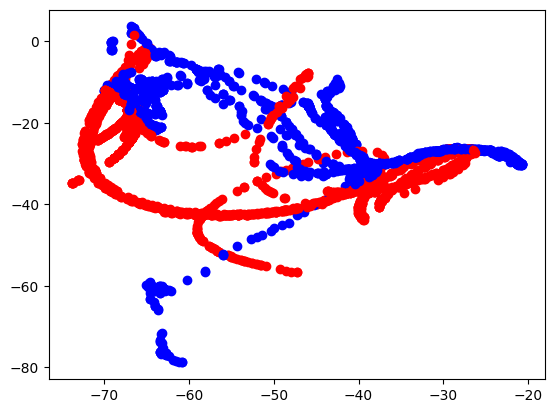

In [105]:
for pred_traj, obs_traj in zip(predicted_trajectories_lat_lon, observed_trajectories_lat_lon):
    plt.scatter(pred_traj[:,0], pred_traj[:,1], label = "predicted", color = "r")
    plt.scatter(obs_traj[:,0], obs_traj[:,1], label = "observed", color = "b")
    # break